# Reasonable Suspicion - Terry Stops Prediction  

## Business Understanding 

In 1968, the United States Supreme Court made a landmark decision that made it constitutional for American police to stop and frisk a person if they reasonably suspected that the said person was armed or involved in a crime. Even without probable cause for arrest, an officer does not violate the Fourth Ammendment to the constitution that prohibits unreasonable searches by stopping and frisking a person as long as they have reasonable suspicion.  

Such an investigative 'stop and frisk' stop became widely known as a Terry Stop (from the case *[Terry v Ohio](https://www.law.cornell.edu/supremecourt/text/392/1))* and the data recorded during such stops is available on [Seattle's Official City Government website.](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8)

### Business Problem
To decide on whether or not to make such a stop, an officer is required to pay attention to several factors about the sorrounding, time of day and particulars of the subject. The Seattle Police Department aims to reduce crime by ensuring they **accurately** stop, frisk and arrest as many suspicious individuals as possible. However, they need to strike a balance between stopping criminals and inconveniencing innocent citizens.

### Business Solution
This project aims to use machine learning models to help officers acheive the above goal. The dataset used contains the above factors and intends to use this historical information to help predict whether or not a Terry Stop should be made given prevailing circumstances. 

### Stakeholders
- Seattle Police Department 


## Data Understanding 

Each row in the dataset contains a unique record of a Terry Stop, as reported by the officer conducting the stop. This section will load and explore the data to understand the structure, size and observable patterns.

It will also cover the cleaning and manipulation of the data as will be deemed necessary.  


### Exploratory Data Analysis

In [1]:
# import necessary libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report,
                             precision_score, recall_score, precision_recall_curve, f1_score)
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.metrics import auc
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
#load the data from the csv file and preview the first few rows
df = pd.read_csv('Data/Terry_Stops_20231018.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,56 and Above,-1,20160000325874,191650,Offense Report,None,6672,1966,M,White,...,17:26:00.0000000,NUISANCE - MISCHIEF,--MISCHIEF OR NUISANCE - GENERAL,ONVIEW,SOUTHWEST PCT OPS - CPT,N,N,Southwest,F,F2
1,26 - 35,-1,20180000368757,488017,Offense Report,None,5350,1964,M,White,...,18:38:00.0000000,-,-,-,PAWN DETAIL,N,N,North,N,N2
2,18 - 25,-1,20150000297988,80973,Offense Report,None,7463,1981,M,White,...,10:55:00.0000000,DIST - IP/JO - DV DIST - NO ASLT,--DV - DOMESTIC VIOLENCE (ARREST DISCRETIONARY),911,SOUTH PCT 1ST W - SAM - PLATOON 2,N,N,South,S,S2
3,18 - 25,-1,20150000294181,77162,Offense Report,None,5288,1960,M,Not Specified,...,12:03:00.0000000,THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING),--DISTURBANCE - OTHER,911,NORTH PCT 1ST W - NORA (JOHN) - PLATOON 1,N,N,North,N,N2
4,26 - 35,-1,20170000004647,315588,Field Contact,None,5438,1958,M,White,...,13:03:00.0000000,-,-,-,SOUTHWEST PCT 2ND W - SOUTHWEST BEATS,N,N,-,-,-


In [3]:
#check number of rows and columns
df.shape

(57730, 23)

In [4]:
#view the names of the columns we're working with. 
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

In [5]:
#view info about the datatypes, counts and null counts for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57730 entries, 0 to 57729
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         57730 non-null  object
 1   Subject ID                57730 non-null  int64 
 2   GO / SC Num               57730 non-null  int64 
 3   Terry Stop ID             57730 non-null  int64 
 4   Stop Resolution           57730 non-null  object
 5   Weapon Type               57730 non-null  object
 6   Officer ID                57730 non-null  object
 7   Officer YOB               57730 non-null  int64 
 8   Officer Gender            57730 non-null  object
 9   Officer Race              57730 non-null  object
 10  Subject Perceived Race    57730 non-null  object
 11  Subject Perceived Gender  57730 non-null  object
 12  Reported Date             57730 non-null  object
 13  Reported Time             57730 non-null  object
 14  Initial Call Type     

In [6]:
#Choose usable columns relevant to the goals of this project
usable_features = ['Subject Age Group','Weapon Type', 'Officer Gender','Officer Race', 'Subject Perceived Race',
                    'Subject Perceived Gender', 'Arrest Flag', 'Reported Date', 'Reported Time' ,'Officer YOB']
sub_df = df[usable_features]

In [7]:
#preview records in the new dataframe
sub_df.head()

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Arrest Flag,Reported Date,Reported Time,Officer YOB
0,56 and Above,None,M,White,White,Male,N,2016-09-08T00:00:00Z,17:26:00.0000000,1966
1,26 - 35,None,M,White,White,Female,N,2018-10-02T00:00:00Z,18:38:00.0000000,1964
2,18 - 25,None,M,White,Black or African American,Male,N,2015-08-26T00:00:00Z,10:55:00.0000000,1981
3,18 - 25,None,M,Not Specified,Black or African American,Male,N,2015-08-23T00:00:00Z,12:03:00.0000000,1960
4,26 - 35,None,M,White,White,Male,N,2017-10-06T00:00:00Z,13:03:00.0000000,1958


In [8]:
sub_df.columns

Index(['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Arrest Flag',
       'Reported Date', 'Reported Time', 'Officer YOB'],
      dtype='object')

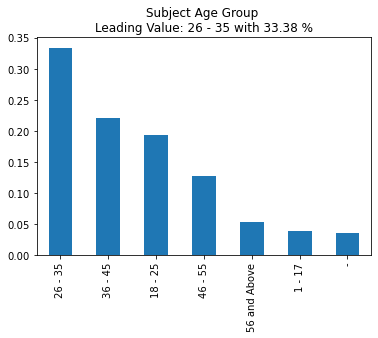

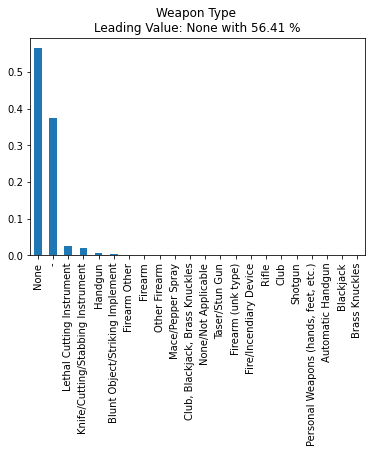

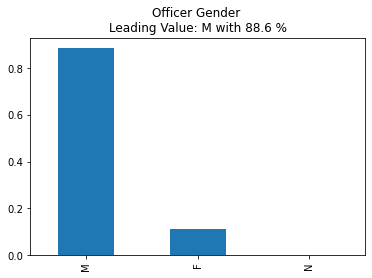

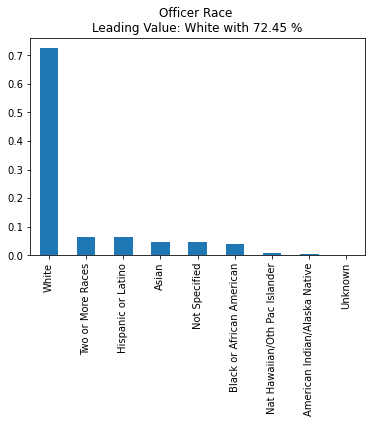

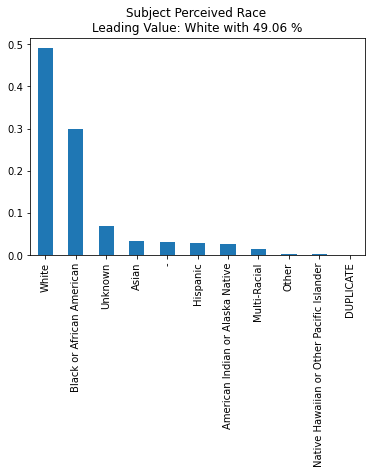

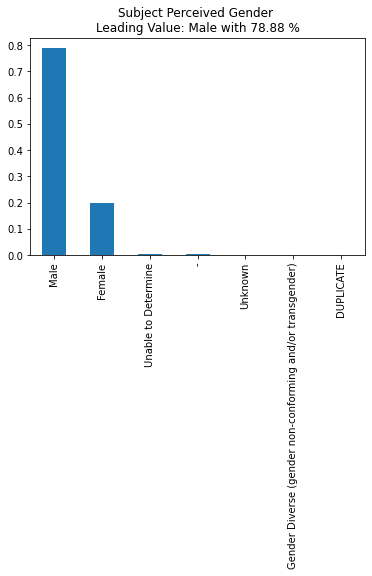

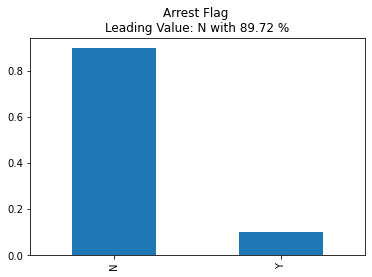

In [9]:
#For each of the selected columns (except day and dates), 
# visually inspect the distribution of the values contained 

for column in usable_features[:-3]:
    val_count = df[column].value_counts( normalize=True)
    val_count.plot.bar(title = f'{column} \nLeading Value: {val_count.index[0]} with { str(round(val_count.values[0]*100, 2))} %')

    
    plt.show()

    

Below, View history of monthly Terry Stops recorded over time (2015 - 2023)

<ipython-input-10-1e55a6476751>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Reported Date'] = sub_df['Reported Date'].apply ( lambda x: pd.to_datetime(x))
<ipython-input-10-1e55a6476751>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['count'] = 1


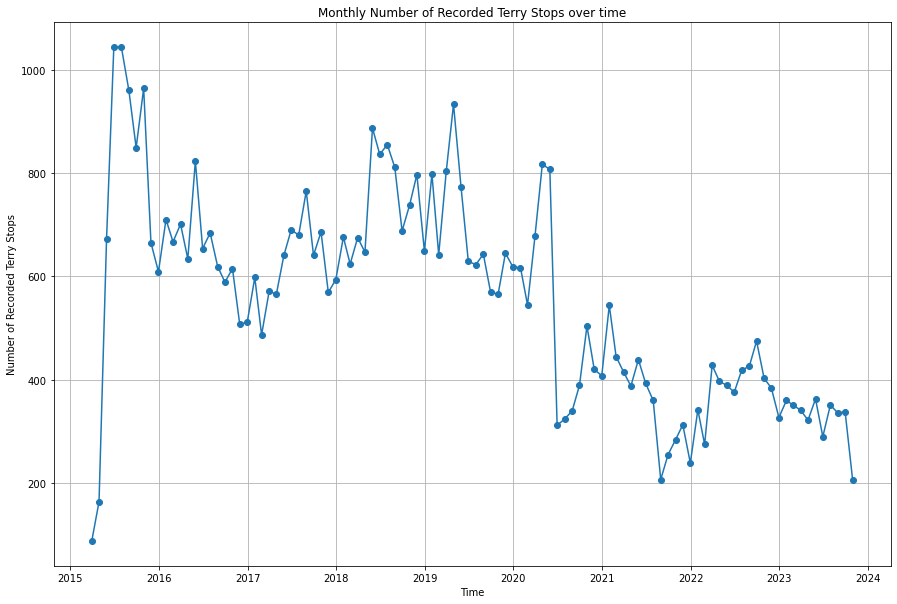

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Arrest Flag,Reported Date,Reported Time,Officer YOB
0,56 and Above,None,M,White,White,Male,N,2016-09-08 00:00:00+00:00,17:26:00.0000000,1966
1,26 - 35,None,M,White,White,Female,N,2018-10-02 00:00:00+00:00,18:38:00.0000000,1964
2,18 - 25,None,M,White,Black or African American,Male,N,2015-08-26 00:00:00+00:00,10:55:00.0000000,1981
3,18 - 25,None,M,Not Specified,Black or African American,Male,N,2015-08-23 00:00:00+00:00,12:03:00.0000000,1960
4,26 - 35,None,M,White,White,Male,N,2017-10-06 00:00:00+00:00,13:03:00.0000000,1958
...,...,...,...,...,...,...,...,...,...,...
57725,36 - 45,None,M,Two or More Races,American Indian or Alaska Native,Male,N,2016-07-29 00:00:00+00:00,18:48:00.0000000,1988
57726,36 - 45,None,M,Not Specified,Black or African American,Male,N,2017-09-23 00:00:00+00:00,09:08:00.0000000,1986
57727,26 - 35,Handgun,M,White,Black or African American,Male,N,2018-02-28 00:00:00+00:00,11:39:00.0000000,1983
57728,46 - 55,Handgun,M,White,White,Male,N,2018-08-12 00:00:00+00:00,18:13:00.0000000,1993


In [10]:
#plot of terry stops over time

#convert values to to datetime 
sub_df['Reported Date'] = sub_df['Reported Date'].apply ( lambda x: pd.to_datetime(x))

#resample to aggregate values per day
sub_df['count'] = 1 
daily_counts  = sub_df.resample('M', on='Reported Date')['count'].sum()

#plot
plt.figure(figsize=(15,10))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-')

plt.xlabel('Time')
plt.ylabel('Number of Recorded Terry Stops')
plt.title('Monthly Number of Recorded Terry Stops over time')
plt.grid(True)
plt.show();

sub_df.drop('count', axis=1)

From the plots above, we can make the following obeservations:
* Most Terry stops (90%) ended up with no arrests. **This may suggest class imbalance**
* Male subjects were stopped most, at 79%
* People with 'White' as their perceived race were stopped most, at 49%
* Officers with 'White' as race on record made the most stops, at 49%
* The most common subject age group was 26-35 years (33%)

### Data Preparation

In [11]:
#Check for null values in sub_df
sub_df.isna().sum()

Subject Age Group           0
Weapon Type                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Arrest Flag                 0
Reported Date               0
Reported Time               0
Officer YOB                 0
count                       0
dtype: int64

In [12]:
#preview data as we have it
sub_df.head()

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Arrest Flag,Reported Date,Reported Time,Officer YOB,count
0,56 and Above,None,M,White,White,Male,N,2016-09-08 00:00:00+00:00,17:26:00.0000000,1966,1
1,26 - 35,None,M,White,White,Female,N,2018-10-02 00:00:00+00:00,18:38:00.0000000,1964,1
2,18 - 25,None,M,White,Black or African American,Male,N,2015-08-26 00:00:00+00:00,10:55:00.0000000,1981,1
3,18 - 25,None,M,Not Specified,Black or African American,Male,N,2015-08-23 00:00:00+00:00,12:03:00.0000000,1960,1
4,26 - 35,None,M,White,White,Male,N,2017-10-06 00:00:00+00:00,13:03:00.0000000,1958,1


#### Re-Group Weapon Type column

In [13]:
#Have a look again at the Weapon Type Column
sub_df['Weapon Type'].value_counts( normalize=True)

None                                    0.564091
-                                       0.373307
Lethal Cutting Instrument               0.025671
Knife/Cutting/Stabbing Instrument       0.020197
Handgun                                 0.006444
Blunt Object/Striking Implement         0.002616
Firearm Other                           0.001732
Firearm                                 0.001611
Other Firearm                           0.001057
Mace/Pepper Spray                       0.000918
Club, Blackjack, Brass Knuckles         0.000849
None/Not Applicable                     0.000277
Taser/Stun Gun                          0.000260
Firearm (unk type)                      0.000260
Fire/Incendiary Device                  0.000208
Rifle                                   0.000173
Club                                    0.000156
Shotgun                                 0.000069
Personal Weapons (hands, feet, etc.)    0.000035
Automatic Handgun                       0.000035
Blackjack           

From the info above, the Weapon Type column is heavily skewed and to reduce the number of resultant columns when we use one hot encoding, we can group weapons that were much less common as 'Others' as below:

In [14]:
common_weapons = ['None', '-', 'Lethal Cutting Instrument', 'Knife/Cutting/Stabbing Instrument' ]
sub_df['Weapon Type'] = sub_df['Weapon Type'].apply( lambda x: np.where(x in common_weapons,
                                 x, 'Others'))

sub_df['Weapon Type'].value_counts( normalize=True)

<ipython-input-14-03d99ec70b4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Weapon Type'] = sub_df['Weapon Type'].apply( lambda x: np.where(x in common_weapons,


None                                 0.564091
-                                    0.373307
Lethal Cutting Instrument            0.025671
Knife/Cutting/Stabbing Instrument    0.020197
Others                               0.016733
Name: Weapon Type, dtype: float64

It is unclear from the dataset what '-' as a weapon type means and while I'd like to group it with 'None', comparing the resulting numner of arrests from None and '-' suggest they have different meanings. See below:

In [15]:
print(sub_df[sub_df['Weapon Type'] == 'None']['Arrest Flag'].value_counts(normalize= True))
print(sub_df[sub_df['Weapon Type'] == '-']['Arrest Flag'].value_counts(normalize= True))

N    1.0
Name: Arrest Flag, dtype: float64
N    0.757877
Y    0.242123
Name: Arrest Flag, dtype: float64


About a quarter of weapon type '-' led to arrests (all other factors held constant), so we'll keep the value.

#### Convert Reported Date column to weekday or weekend 

In [16]:
#Convert reported date into weekday or weekend 

sub_df['Reported Date'] = sub_df['Reported Date'].apply( lambda x: np.where(x.weekday() > 5, 'Weekend', 'Weekday'))
sub_df['Reported Date'].head()

<ipython-input-16-c3071561bdca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Reported Date'] = sub_df['Reported Date'].apply( lambda x: np.where(x.weekday() > 5, 'Weekend', 'Weekday'))


0    Weekday
1    Weekday
2    Weekday
3    Weekend
4    Weekday
Name: Reported Date, dtype: object

#### Convert Reported Time column into part of day


In [17]:
def get_part_of_day(col): 
    hr = pd.to_datetime(col).hour
    return (
        "morning" if 5 <= hr <= 11
        else
        "afternoon" if 12 <= hr <= 17
        else
        "evening" if 18 <= hr <= 22
        else
        "night"
    )

In [18]:
#convert reported time into period of the day
sub_df['Reported Time'] = sub_df['Reported Time'].apply(lambda x: get_part_of_day(x))
sub_df['Reported Time'].head()

<ipython-input-18-710a1919e305>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Reported Time'] = sub_df['Reported Time'].apply(lambda x: get_part_of_day(x))


0    afternoon
1      evening
2      morning
3    afternoon
4    afternoon
Name: Reported Time, dtype: object

#### Convert Arrest Flag Column into 0 or 1

In [19]:
sub_df['Arrest Flag'] = (sub_df['Arrest Flag'] == 'Y').astype(int)

<ipython-input-19-8aef256dbebe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Arrest Flag'] = (sub_df['Arrest Flag'] == 'Y').astype(int)


Text(0.5, 1.0, 'Distribution of target variable')

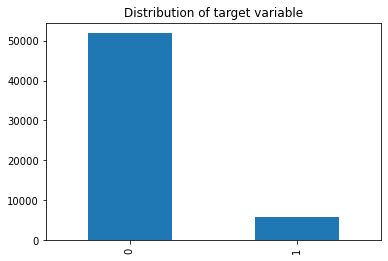

In [20]:
sub_df['Arrest Flag'].value_counts().plot.bar()
plt.title("Distribution of target variable")

In [21]:
#define categorical columns
cat_columns = ['Subject Age Group',
 'Weapon Type',
 'Officer Gender',
 'Officer Race',
 'Subject Perceived Race',
 'Subject Perceived Gender',
 'Reported Date',
 'Reported Time']

In [22]:
sub_df

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Arrest Flag,Reported Date,Reported Time,Officer YOB,count
0,56 and Above,None,M,White,White,Male,0,Weekday,afternoon,1966,1
1,26 - 35,None,M,White,White,Female,0,Weekday,evening,1964,1
2,18 - 25,None,M,White,Black or African American,Male,0,Weekday,morning,1981,1
3,18 - 25,None,M,Not Specified,Black or African American,Male,0,Weekend,afternoon,1960,1
4,26 - 35,None,M,White,White,Male,0,Weekday,afternoon,1958,1
...,...,...,...,...,...,...,...,...,...,...,...
57725,36 - 45,None,M,Two or More Races,American Indian or Alaska Native,Male,0,Weekday,evening,1988,1
57726,36 - 45,None,M,Not Specified,Black or African American,Male,0,Weekday,morning,1986,1
57727,26 - 35,Others,M,White,Black or African American,Male,0,Weekday,morning,1983,1
57728,46 - 55,Others,M,White,White,Male,0,Weekend,evening,1993,1


## Feature Engineering
This section takes the data as prepared in the above section and converts it into a format friendly to our regression library, sklearn in particular. It also defines our target and predictor variables.  

In [23]:
#separate target and independent variables
# all columns are categorical
y = sub_df['Arrest Flag']
X = sub_df[cat_columns]

In [24]:
#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25, random_state = 42)


In [25]:
#transform categorical variables to numerical (train data)
X_train = pd.get_dummies(X_train, drop_first=True)
X_train

,Subject Age Group_1 - 17,Subject Age Group_18 - 25,Subject Age Group_26 - 35,Subject Age Group_36 - 45,Subject Age Group_46 - 55,Subject Age Group_56 and Above,Weapon Type_Knife/Cutting/Stabbing Instrument,Weapon Type_Lethal Cutting Instrument,Weapon Type_None,Weapon Type_Others,...,Subject Perceived Gender_DUPLICATE,Subject Perceived Gender_Female,Subject Perceived Gender_Gender Diverse (gender non-conforming and/or transgender),Subject Perceived Gender_Male,Subject Perceived Gender_Unable to Determine,Subject Perceived Gender_Unknown,Reported Date_Weekend,Reported Time_evening,Reported Time_morning,Reported Time_night
46372,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12537,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
20177,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
27838,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
5222,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13304,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
56825,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
40798,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
49712,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [26]:
#get dummies for X_test
X_test = pd.get_dummies(X_test, drop_first=True)
X_test

,Subject Age Group_1 - 17,Subject Age Group_18 - 25,Subject Age Group_26 - 35,Subject Age Group_36 - 45,Subject Age Group_46 - 55,Subject Age Group_56 and Above,Weapon Type_Knife/Cutting/Stabbing Instrument,Weapon Type_Lethal Cutting Instrument,Weapon Type_None,Weapon Type_Others,...,Subject Perceived Gender_DUPLICATE,Subject Perceived Gender_Female,Subject Perceived Gender_Gender Diverse (gender non-conforming and/or transgender),Subject Perceived Gender_Male,Subject Perceived Gender_Unable to Determine,Subject Perceived Gender_Unknown,Reported Date_Weekend,Reported Time_evening,Reported Time_morning,Reported Time_night
39901,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
11089,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
869,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
34324,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
18084,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5327,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
17280,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0
5597,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
17587,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## Modelling 

#### Logistic Regression Model

Since this is a classification task, we'll start with logistic regression to determine whether or not a Terry stop should be made given the information contained in our predictor variables. \
Below, we initiate the model with the following parameters to prevent overfitting:
* **fit_intercept = False:** We'll not be fitting an intercept term because our dataset is relatively small and we're using C
* **C=1e12:** C is the inverse of regularization strength. We're telling the model to have very low regularization.
* **solver = 'liblinear':** we choose liblinear as the algorithm to use for optimizing our model's loss function. It can handle both L1 and L2 regularization

In [27]:
#initiate
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
#Fit the model
log_model = logreg.fit(X_train, y_train)
#make predictions
y_preds = logreg.predict(X_test)


In [28]:
#calculate accuracy
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8972493591076006


The model has 89% accuracy, which can be considered a good score. But is it, really? Let's find out using a confusion matrix and a classification report

In [29]:
print(classification_report(y_test, y_preds))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95     12950
           1       0.50      0.00      0.01      1483

    accuracy                           0.90     14433
   macro avg       0.70      0.50      0.48     14433
weighted avg       0.86      0.90      0.85     14433



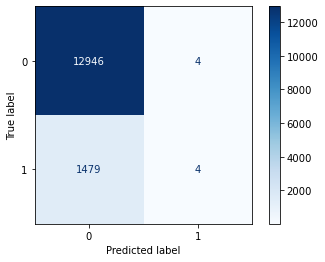

In [30]:
#create confusion matrix
cnf_mtrx = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtrx, display_labels=log_model.classes_)
disp.plot(cmap=plt.cm.Blues);

The confusion matrix above shows: \
12,946 true positives\
1479 false positives \
4 false negatives\
4 true negatives 

Out of the the 12,950 '0' labels, only 4 were incoreectly classified. \
However, 1479 of the 1483 '1' labels were incorrectly classified.

The model has a very high false negative rate, probably due to class imbalance. In the test set, 89% of the values belonged to class '0'

Below, we'll calculate the AUC and plot the ROC AUC curve:


Train AUC: 0.8683123709464644
Test AUC: 0.8689430013772563


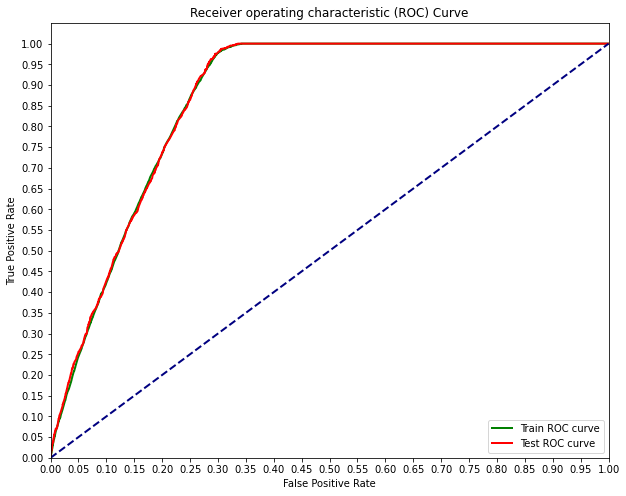

In [31]:
#calculate the train score
y_train_score = logreg.decision_function(X_train)

# calculate the test score 
y_test_score = logreg.decision_function(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_score)

print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='green',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='red',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The Train and Test AUC are very close, which suggests that the model generalizes well. However, this model suffers from class imbalance and does not apply cross validation, which could lead to over confidence in the model's performance.

**Applying business context, applying this model would lead to very many suspicious drivers not being arrested. Consequences of failing to arrest a potential criminal are more serious than if an innocent person was arrested.**

We will therefore be optimizing for recall score.

#### Weighting the Logistic Regression due to class Imbalance

Label Distribution: 0.1145433133193042


Text(0.5, 1.0, 'Distribution of Arrests vs Non-arrests ')

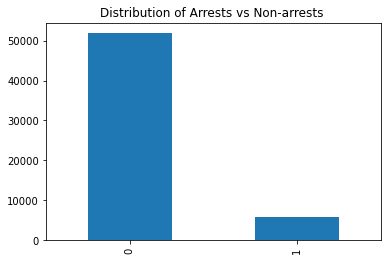

In [32]:
#preview the distribution of the classes again:
sub_df['Arrest Flag'].value_counts().plot.bar()
distribution_ratio =  sub_df['Arrest Flag'].value_counts()[1]/sub_df['Arrest Flag'].value_counts()[0]
print(f"Label Distribution: {distribution_ratio}")
plt.title("Distribution of Arrests vs Non-arrests ")

In [33]:
y_test.value_counts()

0    12950
1     1483
Name: Arrest Flag, dtype: int64

In [34]:
# convert 0.115 to fraction:
import math
gcd = math.gcd (115,1000)
print(f"Distribution Ratio: {115/gcd}/{1000/gcd}")

Distribution Ratio: 23.0/200.0


With the first model, we'll try using the inverse of class weights.

Test Area Under Curve: 0.839831552967089
Train Area Under Curve: 0.8388895155671211
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     12950
           1       0.27      0.98      0.43      1483

    accuracy                           0.73     14433
   macro avg       0.64      0.84      0.63     14433
weighted avg       0.92      0.73      0.78     14433



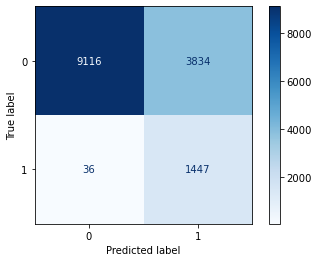

In [35]:
#define inverted class weights:
w = {0:23, 1:200}

#instantiate, fit and predict
lg2 = LogisticRegression(random_state=42, class_weight= w, fit_intercept=False, C=1e12, solver='liblinear')
lg2.fit(X_train, y_train)
lg2_preds = lg2.predict(X_test)

#performance: 
print(f'Test Area Under Curve: {roc_auc_score(y_test, lg2_preds)}')
print(f'Train Area Under Curve: {roc_auc_score(y_train, lg2.predict(X_train))}')


print(classification_report(y_test, lg2_preds))


cnf_mtrx = confusion_matrix(y_test, lg2_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtrx, display_labels=lg2.classes_)
disp.plot(cmap=plt.cm.Blues);

* This model predicted 1447 out of 1483 arrests correctly, which is a huge improvement!
* However, precision really took a hit and dropped to 27%. This means that we would be stopping a lot of people unncesarily who would turn out to be false negatives. The model predicts 3,834 wrong arrests.
* The test and train AUC are close, so the model generalizes well too. 

#### Logistic Regression with GridsearchCV 

While the model above would help us arrest 98% of people that do need to be arrested, it would be at the expense of a lot others who don't deserve to be arrested. Perhaps we should find a balance. 

The class weights used in the above model were simply inverted class distribution ratios. Let's try other value combinations using GridsearchCV. To try and acheive the said balance, we'll optimize for f1 score.

In [36]:
# Define the custom class weights
custom_class_weights = {0: list(range(13, 33)), 1: list(range(190, 210))}

# Define the hyperparameter grid
hyperparam_grid = {
    "class_weight": [None, "balanced", custom_class_weights]
}

# Define the model
lg3 = LogisticRegression(random_state=42, fit_intercept=False, C=1e12, solver='liblinear')

# Define the evaluation procedure
grid = GridSearchCV(lg3, hyperparam_grid, scoring="f1", cv=5)
grid.fit(X_train, y_train)

# Print the best score and parameters
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}');


c:\Users\Libellule\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'list'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Libellule\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Libellule\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1356, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Libellule\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py", line 930, in _fit_liblinear
    class_weight_ = compute_class_weight(class_weight, classes=classes_,
  File "c:\Users\Libell

Best score: 0.4251216758691331 with param: {'class_weight': 'balanced'}


Best f1 score we found was 0.43 with 'balanced' as class weight. Let's create a new model with these parameters

Test Area Under Curve: 0.839831552967089
Train Area Under Curve: 0.8388766445603509
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     12950
           1       0.27      0.98      0.43      1483

    accuracy                           0.73     14433
   macro avg       0.64      0.84      0.63     14433
weighted avg       0.92      0.73      0.78     14433



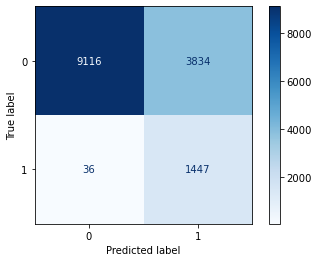

In [37]:
#create model with parameters from above

#instantiate, fit and predict
lg4 = LogisticRegression(random_state=42, class_weight= 'balanced', fit_intercept=False, C=1e12, solver='liblinear')
lg4.fit(X_train, y_train)
lg4_preds = lg2.predict(X_test)

#performance: 
print(f'Test Area Under Curve: {roc_auc_score(y_test, lg4_preds)}')
print(f'Train Area Under Curve: {roc_auc_score(y_train, lg4.predict(X_train))}')


print(classification_report(y_test, lg4_preds))


cnf_mtrx = confusion_matrix(y_test, lg4_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtrx, display_labels=lg4.classes_)
disp.plot(cmap=plt.cm.Blues);

The only difference here was a very marginal decrease in train area under curve. For Logistic regression models, the one with invereted class weights appears to be the best.

Below, let's try another type of classification algorithm.

### Decision Tree

 A decision starts by selecting a feature from the training data. This feature is the one that best splits the data into two groups. The algorithm then recursively splits the data into smaller and smaller groups, using different features at each split. The process stops when all of the data points in a group belong to the same class or a specified maximum depth is reached.


test Area under the curve: 0.5296993988497697
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12950
           1       0.33      0.08      0.13      1483

    accuracy                           0.89     14433
   macro avg       0.62      0.53      0.53     14433
weighted avg       0.84      0.89      0.86     14433



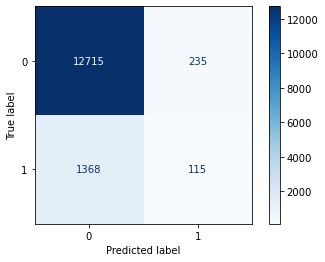

In [38]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X_train, y_train)
#get predictions on X_test
preds = clf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds, = roc_curve(y_test, preds)
roc_auc= auc (false_positive_rate, true_positive_rate)
print(f"test Area under the curve: {roc_auc}")

print(classification_report(y_test, preds))
cnf_mtrx = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtrx, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues);

The model performs fairly similar to the base logistic regression model. Below, we'll tune the max depth to see if we can improve the perfomance. 

#### Decision Tree Hyperparameter tuning

Finding optimal tree depth: 

In [39]:
#try running through 1-30 as max_depth to find optimal value
max_depth =list(range (1, 31))
train_results = []
test_results = []
for i in max_depth:
    # initiate classifier and fit to training set
    clf = DecisionTreeClassifier(criterion= 'entropy', max_depth= i , random_state= 1)
    clf.fit(X_train, y_train)
    #predict train set and add results to train results
    train_preds = clf.predict(X_train)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, train_preds)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    #predict the test set and add results to test results
    test_pred = clf.predict(X_test)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)




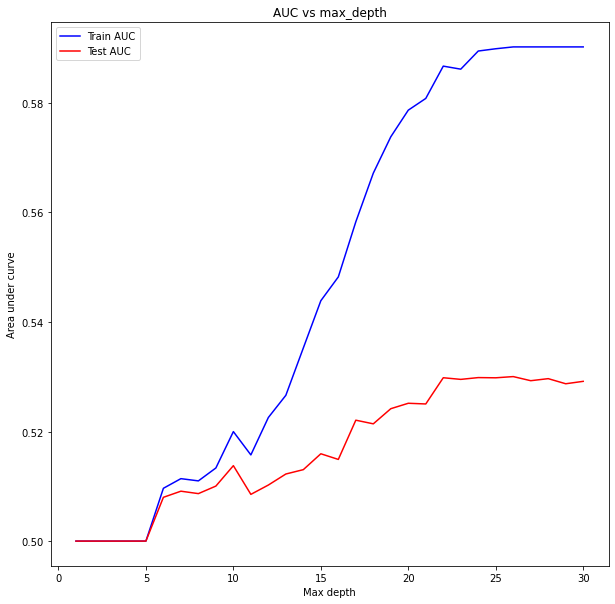

In [40]:
#plot above results
plt.figure(figsize= (10,10))
plt.plot(max_depth, train_results, color = 'b', label = 'Train AUC')
plt.plot(max_depth, test_results, color = 'r', label = "Test AUC")
# plt.ylim(0,1)
plt.xlabel("Max depth")
plt.ylabel("Area under curve")
plt.title("AUC vs max_depth")
plt.legend()
plt.show()


From the graph above,the train AUC value keeps rising as expected while the model learns more and more about the training data. The test AUC rises up to about 6 and later at around 10 and they both flatten at around 23. 

Here, I assume that the AUC wasn't rising anymore for any of the tests so it must be close to the ideal number of branches. It is worth noting that the AUC value is still under 60%, so this may not be considered a very good classifier (at least not yet). 
Below, creating a model with 23 as the max_depth

Test Area Under Curve: 0.53000827915865
Train Area Under Curve: 0.5858701624899526
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12950
           1       0.34      0.08      0.13      1483

    accuracy                           0.89     14433
   macro avg       0.62      0.53      0.53     14433
weighted avg       0.84      0.89      0.86     14433



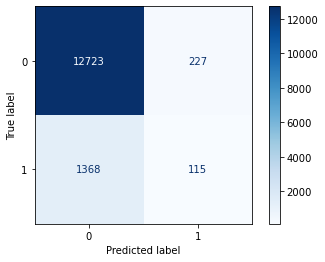

In [41]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy', max_depth=23)
clf.fit(X_train, y_train)

#get predictions on X_test
clf_preds = clf.predict(X_test)

#performance: 

print(f'Test Area Under Curve: {roc_auc_score(y_test, clf_preds)}')
print(f'Train Area Under Curve: {roc_auc_score(y_train, clf.predict(X_train))}')
print(classification_report(y_test, clf_preds))

cnf_mtrx = confusion_matrix(y_test, clf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtrx, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues);

Interpretation:
The model performs only slightly worse with 23 as the max depth. However, we're running the risk of overfitting with such depths. 

#### GridsearchCV with Decision Tree

In [42]:
#define hyper parameters grid
dt_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 3, 4, 5, 6],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
}

In [43]:
#finding the best parameters - this code may take a while to run

# Instantiate GridSearchCV
dt_clf = DecisionTreeClassifier()

dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Test Area Under Curve: 0.5
Train Area Under Curve: 0.5
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     12950
           1       0.00      0.00      0.00      1483

    accuracy                           0.90     14433
   macro avg       0.45      0.50      0.47     14433
weighted avg       0.81      0.90      0.85     14433



c:\Users\Libellule\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


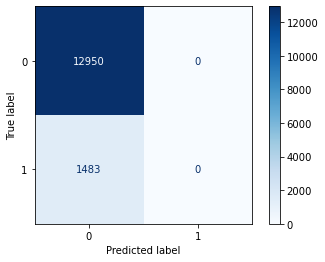

In [44]:
# Use the parameters above to create the last model
grd_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1,min_samples_split=2)
grd_clf.fit(X_train, y_train)

#get predictions on X_test
grd_clf_preds = grd_clf.predict(X_test)

#performance: 

print(f'Test Area Under Curve: {roc_auc_score(y_test, grd_clf_preds)}')
print(f'Train Area Under Curve: {roc_auc_score(y_train, grd_clf.predict(X_train))}')
print(classification_report(y_test, grd_clf_preds))

cnf_mtrx = confusion_matrix(y_test, grd_clf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtrx, display_labels=grd_clf.classes_)
disp.plot(cmap=plt.cm.Blues);

Our final model appears to be the worst performer, which makes sense due to the class imbalance in the data. With only a depth of 2, on a target variable with 23:200 distribution ratio, it's sensible that the algoritm grouped everything as belonging to the majority class.

## Evaluation & Conclusion

In the end, our logistic regression model with inverted class weights ended up being the best performer given our business context. 

While it had a low precison score, the model would allow us to arrest 98% of suspects who should be rightfully taken in. However, it should be used carefully as the high rate of false negatives could have legal consequences for the officer making the Terry Stop. 